In [1]:
import numpy as np
import math
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy
from sklearn import preprocessing
import visdom

/home/hang/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Number of samples 55000 Shape of y[(55000, 10)] Shape of X[(55000, 784)]


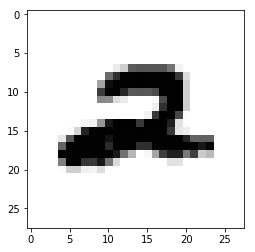

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples
print("Number of samples {} Shape of y[{}] Shape of X[{}]"
      .format(n_samples, mnist.train.labels.shape, mnist.train.images.shape))
plt.imshow(np.reshape(-mnist.train.images[4242], (28, 28)), interpolation='none',cmap=plt.get_cmap('gray'))

plt.show()

In [144]:
# encoder neural network - take as input observation x, output mu and sigma of latent variable z and content h
class Encoder(object):
    def __init__(self,inputs,hidden_dim,z_dim,h_dim):
        self.X=inputs
        self.layer_dims=[6, hidden_dim,hidden_dim, z_dim * 2 + h_dim] # output of Encoder (z_mu, z_sigma, h)
        self.nz=z_dim
        self.nh=h_dim
        with tf.variable_scope('encoder'):
            self.parameters = self._initialize_parameters()
            
    def _initialize_parameters(self):
        L=len(self.layer_dims)
        parameters={}
        for l in range(1,L-1):            
            parameters['W' + str(l)] = tf.get_variable('W'+str(l),[self.layer_dims[l],self.layer_dims[l-1]],initializer=tf.contrib.layers.variance_scaling_initializer())
            parameters['b' + str(l)] = tf.get_variable('b'+str(l),self.layer_dims[l],initializer=tf.zeros_initializer())
        
        w_s = tf.get_variable('w_s',[self.nz,self.layer_dims[L-2]],initializer=tf.contrib.layers.variance_scaling_initializer(factor=0.002))
        w_o = tf.get_variable('w_o',[self.nz+self.nh,self.layer_dims[L-2]],initializer=tf.contrib.layers.variance_scaling_initializer())
        parameters['W'+str(L-1)] = tf.concat([w_s,w_o],axis = 0,name='W'+str(L-1))
        parameters['b'+str(L-1)] = tf.get_variable('b'+str(L-1),self.layer_dims[L-1],initializer=tf.zeros_initializer())
        return parameters
    
    def encoding(self):
        W1 = tf.get_variable("Wc1", [4, 4, 1, 8], initializer=tf.contrib.layers.xavier_initializer())
        L=len(self.layer_dims)    
        A=self.X
        
        Z=tf.nn.conv2d(A, W1, strides=[1, 1, 1, 1], padding='SAME')
        A1=tf.nn.relu(Z)
        P1 = tf.nn.max_pool(A1, ksize = [1, 8, 8, 1], strides = [1, 8, 8, 1], padding='SAME')
        
        P = tf.contrib.layers.flatten(P1)
#         print(Z.get_shape())
        Z3 = tf.contrib.layers.fully_connected(P, 6, activation_fn=None)
        A=Z3
        for l in range(1,L):
            Z = tf.add(tf.matmul(A,tf.transpose(self.parameters['W'+str(l)])),self.parameters['b'+str(l)])
            if l < (L-1):  # activation for hidden layer
                A = tf.nn.relu(Z)
            else:  # activation for output layer
                A1 = Z[:,:self.nz] #sigma #when initialize, set weights values very small using factor=0.002
                A2 = Z[:,self.nz:2 * self.nz] #mu
                A3 = Z[:,2 * self.nz:] #h
#         print(A1.get_shape())     
        return A1, A2, A3

In [145]:
tf.reset_default_graph()
X=tf.placeholder(shape=[None,28,28,1],dtype=tf.float32)
decoder=Encoder(inputs=X,hidden_dim=500,z_dim=2,h_dim=32)
z_log_sigma_0,z_mu_0,h=decoder.encoding()

In [146]:
# decoder neural network - take as input latent variable z, output reconstructed x_hat
class Decoder(object):
    def __init__(self,inputs,hidden_dim):
        self.X=inputs
        self.nz = 6
        self.layer_dims = [2, hidden_dim,hidden_dim, self.nz]
        with tf.variable_scope('decoder'):
            self.parameters = self._initialize_parameters()
            
    def _initialize_parameters(self):
        L=len(self.layer_dims)
        parameters={}
        for l in range(1,L):            
            parameters['W' + str(l)] = tf.get_variable('W'+str(l),[self.layer_dims[l],self.layer_dims[l-1]],initializer=tf.contrib.layers.variance_scaling_initializer())
            parameters['b' + str(l)] = tf.get_variable('b'+str(l),self.layer_dims[l],initializer=tf.zeros_initializer())
        return parameters
    
    def decoding(self):
        L=len(self.layer_dims)    
        A=self.X
        for l in range(1,L):
            Z = tf.add(tf.matmul(A,tf.transpose(self.parameters['W'+str(l)])),self.parameters['b'+str(l)])
            A = tf.nn.relu(Z)
       
        A = tf.contrib.layers.fully_connected(A, num_outputs=4*4*8, activation_fn=None)
        A = tf.nn.relu(A)
        
        A = tf.reshape(A, (-1,4,4,8))
        
        A = tf.contrib.layers.conv2d_transpose(A, 8, kernel_size=4, stride=7, padding='SAME', activation_fn=None)
#         print(xx.get_shape())
        A = tf.nn.relu(A)
        A = tf.contrib.layers.conv2d_transpose(A, 1, kernel_size=4, stride=1, padding='SAME', activation_fn=None)
#         print(xx.get_shape())
        A = tf.nn.sigmoid(A)
        
        return A 

In [147]:
tf.reset_default_graph()
X=tf.placeholder(shape=[None,2],dtype=tf.float32)
decoder=Decoder(inputs=X,hidden_dim=500)
z_log_sigma_0=decoder.decoding()

In [148]:
# autoregressive neural network - take as input z_(t-1) and h, output mean and sigma of z_(t)
class AutoregNN(object):
    def __init__(self,input_z,input_h,layer_dims,idx,verbose = False):
        self.Z = input_z
        self.h = input_h
        self.z_dim = input_z.get_shape().as_list()[1]
        self.h_dim = input_h.get_shape().as_list()[1]
        self.D= self.z_dim
        self.layer_dims=layer_dims # z_dim + h_dim, arbitrary, arbitrary, z_dim + z_dim
        assert self.layer_dims[0] == self.z_dim + self.h_dim
        assert self.layer_dims[-1] == self.z_dim * 2
        self.verbose = verbose
        
        with tf.variable_scope('autoregressive_nn'+str(idx)):
            self.parameters=self._initialize_parameters()
        with tf.name_scope('autoregressive_nn'+str(idx)):
            self.mask=self.build_mask() 
        
    #initialize parameters
    def _initialize_parameters(self):
        L = len(self.layer_dims)
        parameters={}
        for l in range(1,L):
            
            parameters['W' + str(l)] = tf.get_variable('W'+str(l),[self.layer_dims[l],self.layer_dims[l-1]],initializer=tf.contrib.layers.xavier_initializer())
            parameters['b' + str(l)] = tf.get_variable('b'+str(l),self.layer_dims[l],initializer=tf.zeros_initializer()) 
       
        #for direct connection
        parameters['WA']=tf.get_variable('WA',[self.layer_dims[L-1],self.z_dim],initializer=tf.contrib.layers.xavier_initializer())
        parameters['bA']=tf.get_variable('bA',self.layer_dims[L-1],initializer=tf.zeros_initializer())
        
        return parameters 

    # build mask    
    def single_mask(self, m_h, l, Isoutput=False):
        if l==0:
            raise ValueError('No mask for W0')        
        if Isoutput==False:
            M=np.array([[m_h[l][k]>=m_h[l-1][d] for d in range(self.layer_dims[l-1])] for k in range(self.layer_dims[l])],dtype=int)
        if Isoutput==True:
            M=np.array([[m_h[l][k]>m_h[l-1][d] for d in range(self.layer_dims[l-1])] for k in range(self.layer_dims[l])],dtype=int)
        if self.verbose:
            print('M%d:'%l + '{}'.format(M))
        return M    
    
    def build_mask(self):
        L=len(self.layer_dims)
        mask={}        
        #create mask number of each unit
        input_sel_z = np.arange(0,self.z_dim)
        input_sel_h = np.zeros(self.h_dim)-1 # a little trick to let input h be fully connected to first hidden layer 
                                    # it shouldn't have mask, but we set the mask to be True = set input_sel_h smaller than any mask number
        input_sel = np.concatenate((input_sel_z,input_sel_h))
        output_sel = np.concatenate((input_sel_z, input_sel_z))
        m_h=[input_sel]
        #np.random.seed(0)
        for l in range(1,L-1):
            m_h.append(np.random.randint(self.D-1,size=self.layer_dims[l]))
        m_h.append(output_sel)
        if self.verbose:
            print('m_h: {}'.format(m_h))
        
        for l in range(1,L-1):
            M=self.single_mask(m_h,l,Isoutput=False)
            mask['M'+str(l)]=tf.constant(M,dtype=tf.float32,name='M'+str(l))
        for l in range(L-1,L):           
            M=self.single_mask(m_h,l,Isoutput=True)
            mask['M'+str(l)]=tf.constant(M,dtype=tf.float32,name='M'+str(l))
    
        # for direct connection
        input_sel_direct = input_sel_z
        output_sel_direct = np.concatenate((input_sel_z, input_sel_z))
        M=np.array([[i<j for i in input_sel_direct] for j in output_sel_direct],dtype=int)
        if self.verbose:
            print('MA: {}'.format(M))
        mask['MA']=tf.constant(M,dtype=tf.float32,name='MA')                      
        
        return mask
    
    # forward compute
    def iaf(self):
        L=len(self.layer_dims)    
        A_in=tf.concat((self.Z,self.h),axis = 1)
        A = A_in
        for l in range(1,L):
            masked_W=np.dot(self.parameters['W'+str(l)], self.mask['M'+str(l)])
            b=self.parameters['b'+str(l)]
            Z=tf.add(tf.matmul(A,tf.transpose(masked_W)),b)
            if l < (L-1):  # activation for hidden layer
                A=tf.nn.relu(Z)
            else:  # activation for output layer
                A=Z 
                
        #for direct conection
        masked_W= np.dot(self.parameters['WA'], self.mask['MA'])
        A_direct=tf.matmul(self.Z,tf.transpose(masked_W))
        
        A = tf.add(A,A_direct)
        A1 = A[:,self.z_dim:] #s
        A2 = A[:,:self.z_dim] #m

        
        return A1,A2

In [149]:
# built model
tf.reset_default_graph()
with tf.name_scope('inputs'):
    X = tf.placeholder("float", shape=[None, 28,28,1]) 
    Y = tf.placeholder("float", shape=[None, 10]) 
with tf.name_scope('encoding_stage'):
    encoder=Encoder(inputs=X,hidden_dim=500,z_dim=2,h_dim=32)
    z_log_sigma_0,z_mu_0,h=encoder.encoding()
    epsilon = tf.random_normal(tf.shape(z_mu_0),0,1,dtype=tf.float32)
    Z = np.dot(tf.exp(z_log_sigma_0/2) , epsilon) + z_mu_0

# with tf.name_scope('iaf_stage'):
#     z_sigmas=[]
#     for t in range(4):
#         reverse = t>0
#         if reverse:
#             Z = Z[:,::-1]
#         IAF = AutoregNN(input_z=Z,input_h=h,layer_dims=[34,128,128,4],idx=t)
#         m,s = IAF.iaf()
#         z_sigma = tf.sigmoid(s)
#         Z = np.dot(z_sigma , Z) + np.dot(1 - z_sigma ,  m)
#         z_sigmas.append(z_sigma)

with tf.name_scope('decoding_stage'):
    decoder=Decoder(inputs=Z,hidden_dim=500)
    x_mu_hat = decoder.decoding()
    x_mu_hat = tf.reshape(x_mu_hat, (-1,784))
    X_ = tf.reshape(X,(-1,784))
#     print(x_mu_hat.get_shape())

In [138]:
# vae - iaf negative evidence lower bound - based on monte carlo sampling
def neg_elbo(X,x_mu_hat,Z):
    # log p(x|z_t)
    log_px = -tf.reduce_sum(X_ * tf.log(1e-10 + x_mu_hat) + (1-X_) * tf.log(1e-10 + 1 - x_mu_hat), axis=-1)   
    
    # log p(z_t)
    log_pz = -tf.reduce_sum(0.5*Z**2, axis=-1)
  
    # log q(z_t|x)
#     det=np.zeros_like(z_sigmas[0])
#     for item in z_sigmas:
#         det+=tf.log(item)    
    log_qz = -tf.reduce_sum(0.5*epsilon**2 + 0.5*z_log_sigma_0,axis=-1) 
    
    return tf.reduce_mean(log_px+log_qz-log_pz) 

In [140]:
# training
def training(num_epochs = 1000, batch_size = 32, log_every=10,learning_rate = 0.001, verbose = False):

    with tf.name_scope('training_loss'):
        loss = neg_elbo(X,x_mu_hat,Z)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    
    # training
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        for epoch in range(num_epochs):
            avg_cost = 0.
            num_batch = int(n_samples / batch_size)
            
            for i in range(num_batch):
                mini_batch, mini_label = mnist.train.next_batch(batch_size)
                mini_batch=mini_batch.reshape(-1,28,28,1)
                _,temp_cost,z_values = sess.run([optimizer, loss,z_log_sigma_0], feed_dict={X: mini_batch})
                avg_cost += temp_cost / n_samples * batch_size
#                 print('{}'.format(avg_cost))
            
            if verbose and epoch % log_every ==0:
                save_path = saver.save(sess, "iafmnist/iafmnist.ckpt")
                print('%d-th train ' % (epoch) + 'cost:{} {}'.format(avg_cost,np.mean(z_values)))
    return None

In [142]:
training(num_epochs=10, batch_size = 128, log_every = 1, verbose=True)

INFO:tensorflow:Restoring parameters from iafmnist/iafmnist.ckpt


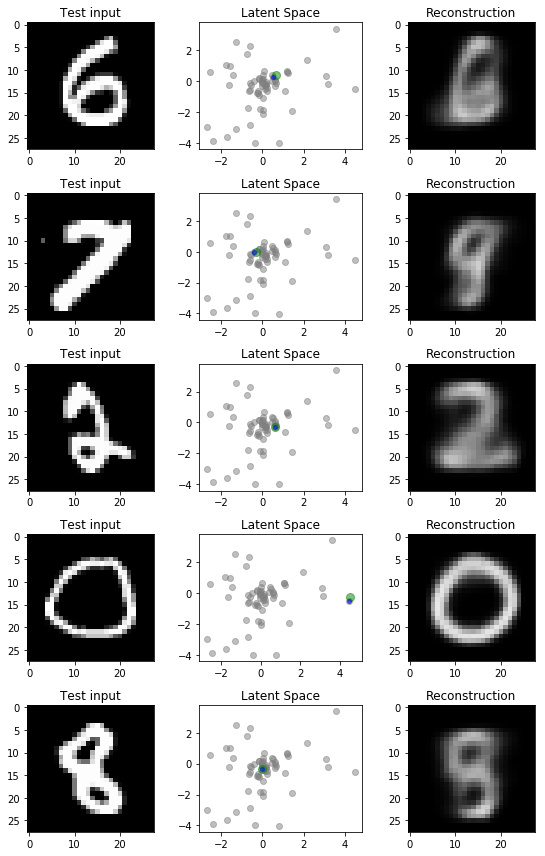

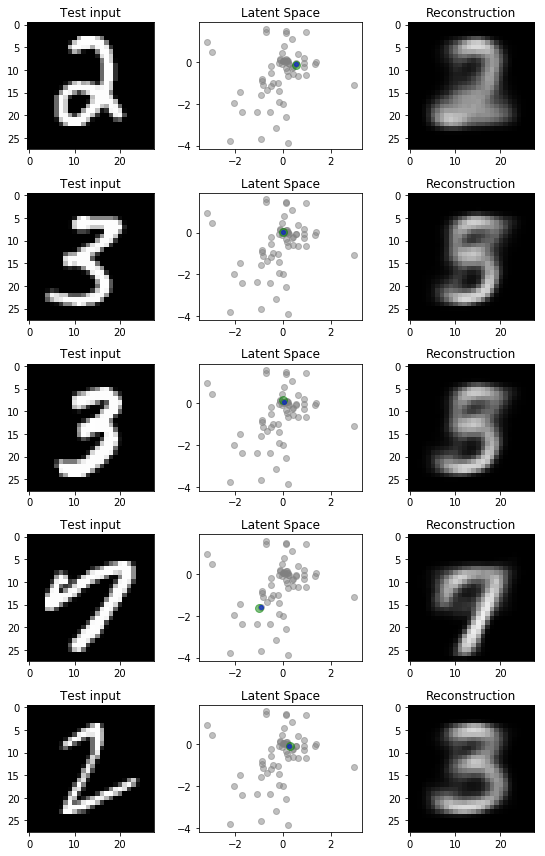

In [37]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, "iafmnist/iafmnist.ckpt")
    x_sample = mnist.test.next_batch(64)[0]
    x_reconstruct,z_vals,z_mean_val,z_log_sigma_0_val  = sess.run((x_mu_hat,Z, z_mu_0, z_log_sigma_0), feed_dict={X: x_sample})

    plt.figure(figsize=(8, 12))
    for i in range(5):
        plt.subplot(5, 3, 3*i + 1)
        plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1,  interpolation='none',cmap=plt.get_cmap('gray'))
        plt.title("Test input")
        
        #plt.colorbar()
        plt.subplot(5, 3, 3*i + 2)
        plt.scatter(z_vals[:,0],z_vals[:,1], c='gray', alpha=0.5)
        plt.scatter(z_mean_val[i,0],z_mean_val[i,1], c='green', s=64, alpha=0.5)
        plt.scatter(z_vals[i,0],z_vals[i,1], c='blue', s=16, alpha=0.5)
               
#         plt.xlim((-3,3))
#         plt.ylim((-3,3))
        plt.title("Latent Space")
        
        plt.subplot(5, 3, 3*i + 3)
        plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, interpolation='none',cmap=plt.get_cmap('gray'))
        plt.title("Reconstruction")
        #plt.colorbar()
    plt.tight_layout()
    plt.show()